# Exploration tool for assessment schemes in ICNIRP 2020 and RPS S-1
author: Dr Vitas Anderson (*Two Fields Consulting*)

date: 13/6/2021

The function below is used to calculate the whole body point spatial distribution over height z:

$\Large L_{wbps} = \frac{k_1}{\textrm{cosh}(k_2(z-z_{source}))}$

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
pd.options.display.max_rows = 201

%matplotlib inline

# uncomment line below to display plots in separate window
# %matplotlib qt  

## Functions

In [2]:
def ass_calc(h,nsap,fMHz,zlow,zhigh,dz,k1,k2,source_heights):
    '''Function which calculates distributions over a set z height range for:
       + point spatial limit normalised field values for whole body exposure (Lwbps)
       + point spatial limit normalised field values for local exposure (Llocps)
       + spatial average of the whole body Lps points (Lwbsa) over a vertical line
       + point spatial representation of the whole body spatial averages (Lwbpssa)
       
       FUNCTION INPUTS:       
          h = height of the spatial averaging window (m)
       nsap = number of spatial averaging points [3 or 5]
       fMHz = exposure frequency in MHz
       zlow = lower bound of the z points (m)
      zhigh = upper bound of the z points (m)
         k1 = parameter that sets the peak level of the Lps distribution
         k2 = parameter that sets the vertical beamwidth of the Lps distribution
         source_heights = list of heights (m) for the source(s), e.g. [10,13]
         
       FUNCTION OUTPUTS:
         distributions of z, Lwbps, Llocps, Lwbsa, Lwbpssa
      '''

    # Generate z distribution
    nz = int((zhigh-zlow) / dz) + 1     # number of z points
    z = np.linspace(zlow, zhigh, nz) 

    # Generate whole body point spatial distribution (Lwbps)
    Lwbps = np.zeros(nz)                  # initialise Lwbps array with zeros
    source_heights = list(source_heights)
    for zs in source_heights:
        Lwbps += k1 / np.cosh(k2*(z-zs))  # add artificial distribution of Lwbps for source i

    # Generate point spatial distribution for local exposure (Llocps)
    if fMHz <= 400:
        m = 5
    elif fMHz < 2000:
        m = 11.47459891 * fMHz**-0.138646884
    else:
        m = 4
    Llocps = Lwbps / m

    # Calculate the wb spatial average (Lwbsa) 
    nh = int(h/dz + 1)       # number of z points within averaging window
    ni = int((nh - 1) / 2)   # number of z points from centre of averaging window to either end

    errmsg = f'Change h ({h}), nsap ({nsap}), &/or dz ({dz}) so that spatial averaging points align with z distribution points'
    assert 2*ni*dz == h, errmsg  

    assert nsap in [3,5], f'nsap ({nsap}) must be 3 or 5'
    if nsap == 3:
        hindeces = [-ni, 0, ni]
    elif nsap == 5:
        ni2 = int(ni/2)
        assert ni == ni2 * 2, errmsg
        hindeces= [-ni, -ni2, 0, ni2, ni]
    hindeces = np.array(hindeces)  # convert list of hpoints into a numpy array

    Lwbsa = np.repeat(np.nan, nz)  # initialise Lwbsa array with NaN's (Not a Number)
    for iz in range(ni, nz-ni):
        Lwbsa[iz] = Lwbps[hindeces + iz].mean()

    # Calculate the point spatial distribution of the wb spatial average (Lwbpssa)
    Lwbpssa = np.repeat(np.nan,len(z)) # initialise Lwbpssa array with Nan's (Not a Number)
    for iz in range(2*ni, nz-2*ni):
        
        # Lwbsa values increasing with height
        if Lwbsa[iz+1] > Lwbsa[iz-1]:  
            Lwbpssa[iz] = Lwbsa[iz-ni]
            
        # Lwbsa values decreasing with height
        else:
            Lwbpssa[iz] = Lwbsa[iz+ni]
            
    # Create pandas dataframe of z and all assessment distributions
    df = pd.DataFrame(dict(z=z,Lwbps=Lwbps,Llocps=Llocps,Lwbsa=Lwbsa,Lwbpssa=Lwbpssa))
    
    # create labels for the L assessment distributions
    labels = ['wb point spatial',
              'local point spatial',
              'wb spatial average',
              'wb point spatial spatial average']
    
    # Create a title for the data set
    title = f'{nsap} points over {h}m\n' + '$k_1$' + f'={k1}, ' + '$k_2$' + f'={k2}, f={fMHz} MHz'
    
    # Create a named tuple for all the L assessment distributions
    Lass = namedtuple("Lass", "Lwbps, Llocps, Lwbsa, Lwbpssa")
    lass = Lass(Lwbps, Llocps, Lwbsa, Lwbpssa)
    
    # Create a named tuple for all the output data
    Ldata = namedtuple("Ldata", "title fMHz labels z zlow zhigh lass df")
    ldata = Ldata(title, fMHz, labels, z, zlow, zhigh, lass, df)

    return ldata

def plotL(L):
    '''Plot the L distributions'''
    fig, ax = plt.subplots(figsize=(4,8))
    for lass, label in zip(L.lass, L.labels):
        ax.plot(lass, L.z, alpha=0.6, label=label)
    ax.set_xlabel('Limit normalised field value')
    ax.set_ylabel('z (m)')
    ax.grid(ls='--')
    ax.legend()
    zmin, zmax = int(L.zlow), int(L.zhigh)
    ax.set_yticks(range(zmin,zmax))
    ax.set_ylim(zmin,zmax)
    ax.set_title(L.title)
    fig.tight_layout()
    
    return ax

## Explore different configurations

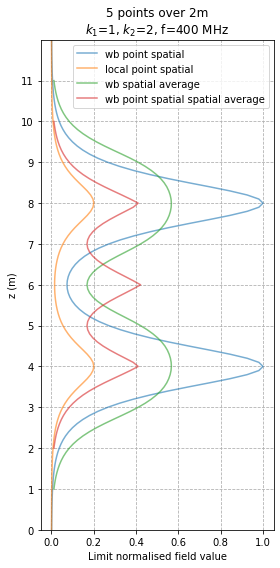

In [3]:
L1 = ass_calc(h=2, nsap=5, fMHz=400,
             zlow=0, zhigh=12, dz=0.1,
             k1=1, k2=2,
             source_heights=[4, 8])

plotL(L1);

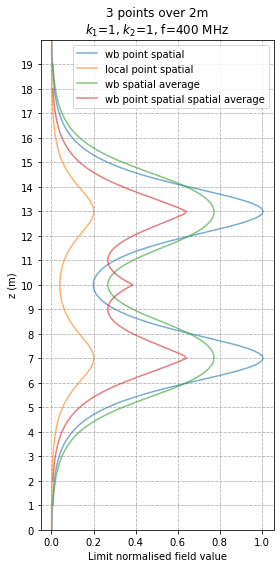

In [4]:
L1 = ass_calc(h=2, nsap=3, fMHz=400,
             zlow=0, zhigh=20, dz=0.1,
             k1=1, k2=1,
             source_heights=[7,13])

plotL(L1);

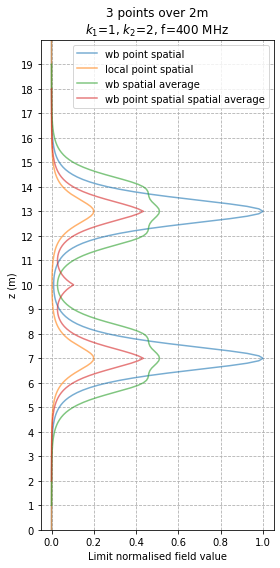

In [5]:
L1 = ass_calc(h=2, nsap=3, fMHz=400,
             zlow=0, zhigh=20, dz=0.1,
             k1=1, k2=2,
             source_heights=[7,13])

plotL(L1);

## Vary k1 and k2 

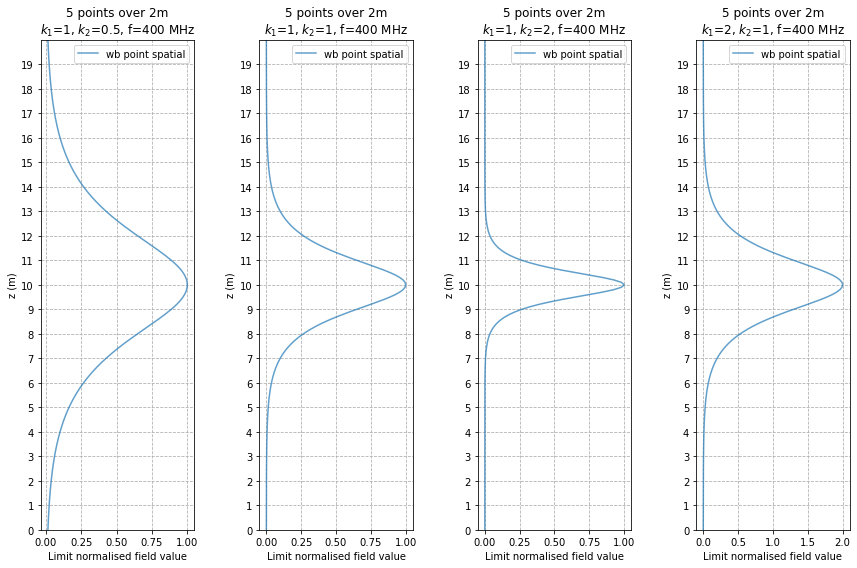

In [22]:
%matplotlib inline
fig, axes = plt.subplots(1,4,figsize=(12,8))
for j, (k1,k2) in enumerate(zip([1,1,1,2],[0.5,1,2,1])):
    L = ass_calc(h=2, nsap=nsap, fMHz=400,
                 zlow=0, zhigh=20, dz=0.1,
                 k1=k1, k2=k2,
                 source_heights=[10])
    ax = axes[j]
    ax.plot(L.lass.Lwbps, L.z, alpha=0.7, label=L.labels[0])
    ax.set_xlabel('Limit normalised field value')
    ax.set_ylabel('z (m)')
    ax.grid(ls='--')
    ax.legend()
    zmin, zmax = int(L.zlow), int(L.zhigh)
    ax.set_yticks(range(zmin,zmax))
    ax.set_ylim(zmin,zmax)
    ax.set_title(L.title)
fig.tight_layout(w_pad=3)
fig.savefig('./plots/k1 k2 plots.png', dpi=100)
        

## Vary nsap and k2 for single source

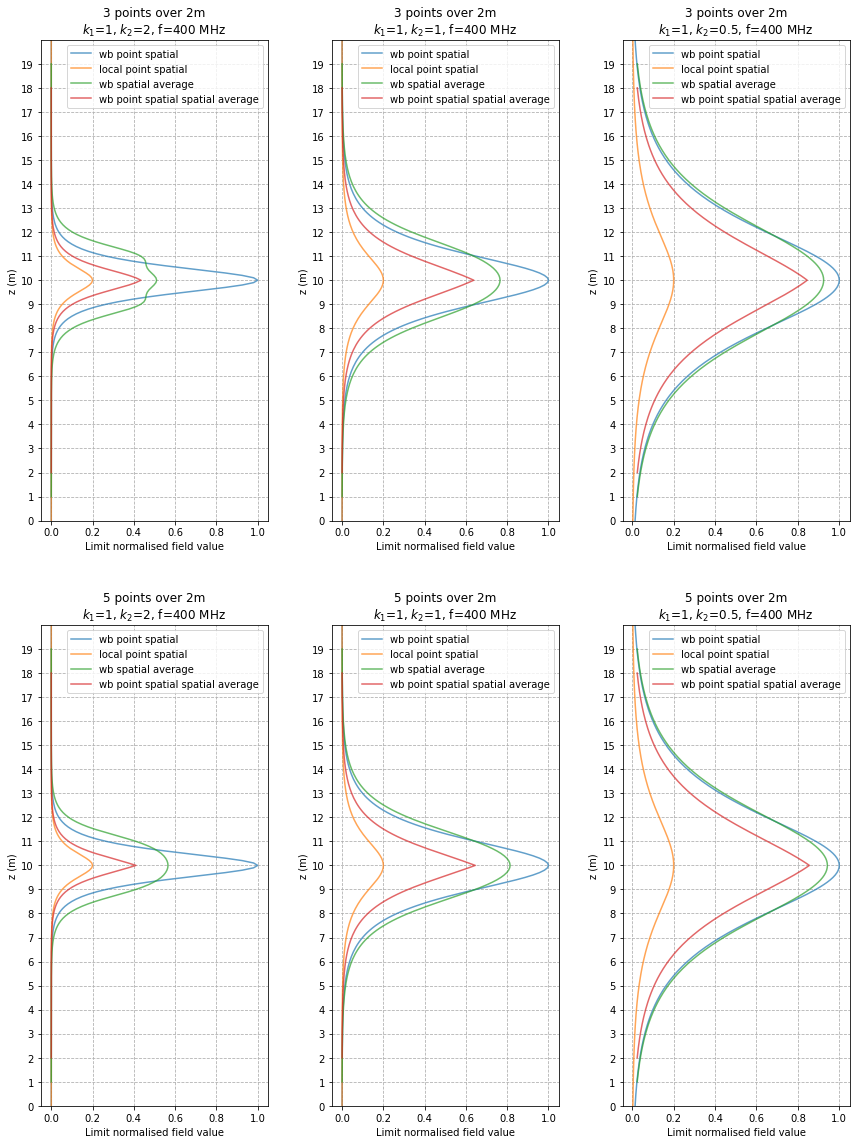

In [21]:
%matplotlib inline
fig, axes = plt.subplots(2,3,figsize=(12,16))
for i, nsap in enumerate([3,5]):
    for j, k2 in enumerate([2, 1, 0.5]):
        L = ass_calc(h=2, nsap=nsap, fMHz=400,
                     zlow=0, zhigh=20, dz=0.1,
                     k1=1, k2=k2,
                     source_heights=[10])
        ax = axes[i,j]
        for lass, label in zip(L.lass, L.labels):
            ax.plot(lass, L.z, alpha=0.7, label=label)
        ax.set_xlabel('Limit normalised field value')
        ax.set_ylabel('z (m)')
        ax.grid(ls='--')
        ax.legend()
        zmin, zmax = int(L.zlow), int(L.zhigh)
        ax.set_yticks(range(zmin,zmax))
        ax.set_ylim(zmin,zmax)
        ax.set_title(L.title)
    fig.tight_layout(h_pad=4,w_pad=3)

fig.savefig('./plots/nsap k2 plots 1source.png', dpi=100)        

## Vary nsap and k2 for two sources

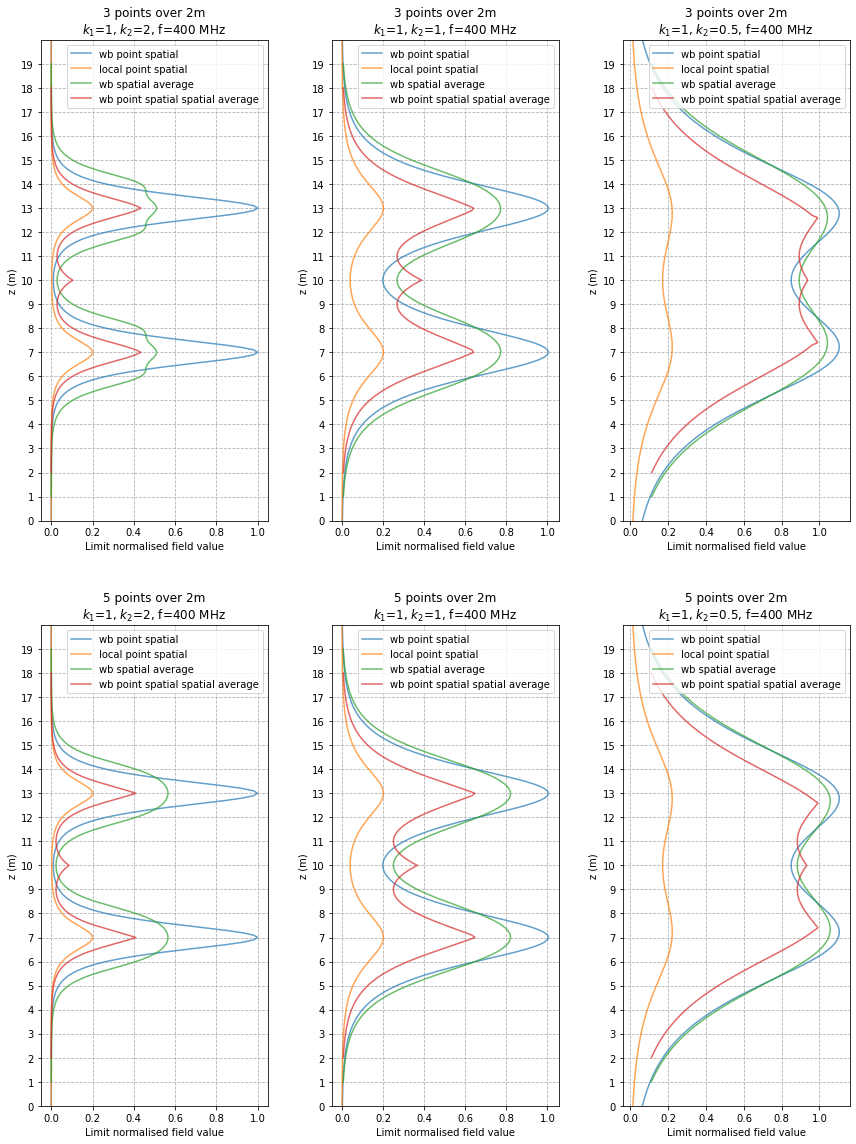

In [20]:
%matplotlib inline
fig, axes = plt.subplots(2,3,figsize=(12,16))
for i, nsap in enumerate([3,5]):
    for j, k2 in enumerate([2, 1, 0.5]):
        L = ass_calc(h=2, nsap=nsap, fMHz=400,
                     zlow=0, zhigh=20, dz=0.1,
                     k1=1, k2=k2,
                     source_heights=[7,13])
        ax = axes[i,j]
        for lass, label in zip(L.lass, L.labels):
            ax.plot(lass, L.z, alpha=0.7, label=label)
        ax.set_xlabel('Limit normalised field value')
        ax.set_ylabel('z (m)')
        ax.grid(ls='--')
        ax.legend()
        zmin, zmax = int(L.zlow), int(L.zhigh)
        ax.set_yticks(range(zmin,zmax))
        ax.set_ylim(zmin,zmax)
        ax.set_title(L.title)
    fig.tight_layout(h_pad=4,w_pad=3)

fig.savefig('./plots/nsap k2 plots 2source.png', dpi=100)
    